In [1]:
using Printf, NCDatasets, Statistics, CairoMakie, JLD, AvailablePotentialEnergyFramework
using LoopVectorization, Tullio, ColorSchemes

In [2]:
function filter_n_times(x,smooth_time,n)
    n == 0 && return x
	if n == 1
		return filter_array_time(x,smooth_time,3)
	else
        for ii in n:-1:1
 	       x = filter_array_time(x,smooth_time,3)
        end
	end
    return x
end

filter_n_times (generic function with 1 method)

In [3]:
data_dir = "$(ENV["SCRATCH"])/for_postprocessing/largencfiles/"
plots_dir = "/global/u2/a/aramreye/RamirezReyes_MECFeedbackInTCWorld/plotsandanimations/"

"/global/u2/a/aramreye/RamirezReyes_MECFeedbackInTCWorld/plotsandanimations/"

In [4]:
nudging_time_list                 = ["5e-1h", "1h", "2h", "3h", "5h", "8h", "5e-1day", "1day", "2day", "5day", "10day",  "15day"]
experiment_labels_for_file = "τ = " .* ["½h", "1h", "2h", "3h", "5h", "8h", "12h", "1d", "2d","5day", "10d",  "15d"];
experiment_labels_for_plot = "τᵣ = " .* ["½h", "1h", "2h", "3h", "5h", "8h", "12h", "1d", "2d","5day", "10d",  "15d"];
push!(experiment_labels_for_plot, "Control");
push!(experiment_labels_for_file, "No nudging");

In [5]:
file_list = string.("f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_",nudging_time_list,"_2d.nc")
push!(file_list,"f5e-4_2km_1000km_homoRad_homoSfc_2d.nc")

13-element Vector{String}:
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_5e-1h_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_1h_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_2h_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_3h_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_5h_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_8h_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_5e-1day_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_1day_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_2day_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_5day_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_10day_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_15day_2d.nc"
 "f5e-4_2km_1000km_homoRad_homoSfc_2d.nc"

In [6]:
function get_timeseries!(buf1,buf2,buf3,file_path)
 	(min_pres,max_speed) = Dataset(file_path) do ds
        sx,sy,st = size(buf1)
        NCDatasets.load!(ds["PSFC"].var,buf1,:,:,:)
        @tullio (min) min_pres[t] := buf1[x,y,t]
        NCDatasets.load!(ds["USFC"].var,buf1,:,:,:)
        NCDatasets.load!(ds["VSFC"].var,buf2,:,:,:)
        @tullio (max) max_speed[t] := sqrt(buf1[x,y,t]*buf1[x,y,t] + buf2[x,y,t]*buf2[x,y,t])
        #@tturbo buf3 .= hypot.(buf1,buf2)
        #max_speed = dropdims(maximum(buf3,dims=(1,2)),dims=(1,2))
        (min_pres,max_speed)
    end
    return (min_pres,max_speed)
end

get_timeseries! (generic function with 1 method)

In [8]:
#buf1_large = Array{Float32,3}(undef,512,512,2400)
#buf2_large = Array{Float32,3}(undef,512,512,2400)
#buf3_large = Array{Float32,3}(undef,512,512,2400);

In [8]:
#data = [get_timeseries!(buf1_large,buf2_large,buf3_large,joinpath(data_dir,file)) for file in file_list];

In [9]:
# times = Dataset(joinpath(data_dir,file_list[1])) do ds
# 	variable(ds,"time")[:]
# end;

In [26]:
#jldopen("max_speed_min_pres.jld","w") do file
#    for (i,experiment) in enumerate(experiment_labels)
#       write(file,"max_speed_$(experiment)",data[i][2])
#       write(file,"min_pres_$(experiment)",data[i][1])
#    end
#    write(file,"times",times)
#end

In [25]:
# buf1_large = []
# buf2_large = []
# buf3_large = []
# GC.gc()

In [7]:
data = load("max_speed_min_pres.jld")
times = data["times"]
min_pressure = [data["min_pres_$(experiment)"] for experiment in experiment_labels_for_file]
max_speed = [data["max_speed_$(experiment)"] for experiment in experiment_labels_for_file];

In [8]:
max_sp = [ mean(timeserie[end - 480 : end]) for timeserie in max_speed]
min_pres = [ mean(timeserie[end - 480 : end]) for timeserie in min_pressure];

In [9]:
window = 12
times_to_smooth = 2
lines_sp = [filter_n_times(timeserie,window,times_to_smooth) for timeserie in max_speed]
lines_pres = [filter_n_times(timeserie,window,times_to_smooth) for timeserie in min_pressure];

In [10]:
threshold_speed = 18 #18m/s tropical storm
genesis_indices = [findfirst(>=(threshold_speed),line_sp) for line_sp in lines_sp];

In [11]:
#This times are going to be used in ape_budget_plots
genesis_times = Float64[]
for genesis_index in genesis_indices
     !isnothing(genesis_index) && push!(genesis_times,times[genesis_index])
end
genesis_times;

In [12]:
set_theme!(fontsize=30,
    Axis = (
        xminorticksvisible = true,
        yminorticksvisible = false,
        xminorgridvisible = true,
        yminorgridvisible = false,
        xticks = LinearTicks(6),
        xminorticks = IntervalsBetween(4)),
    Scatter = (cycle = Cycle([:color, :marker], covary = true),),
    Lines = (cycle = Cycle([:color , :linestyle], covary = false), linewidth = 3.0f0)
)
subplot_label_fontsize = 30.0f0
axis_label_fontsize = 30.0f0
linewidth = 1.5f0
legend_labelsize = 30.0f0

30.0f0

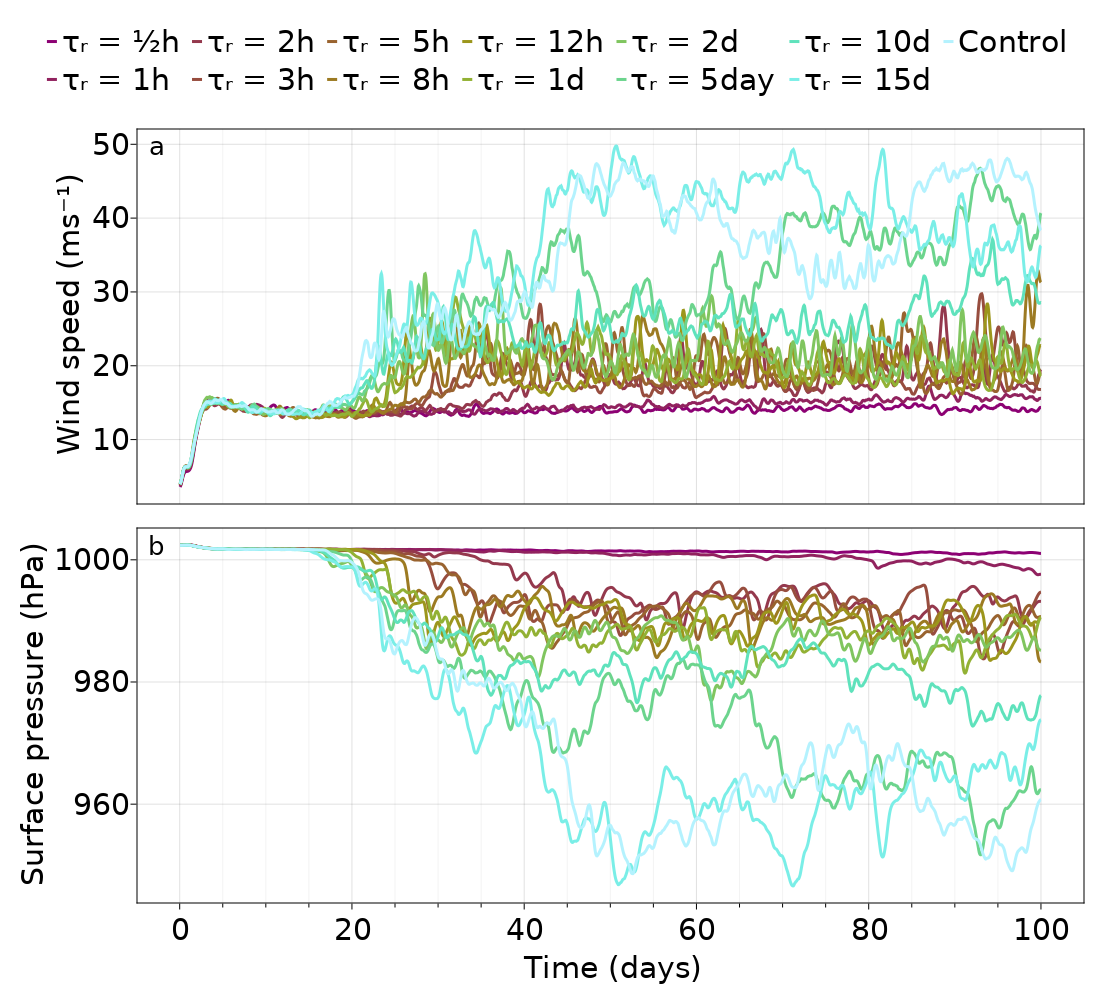

In [13]:
fig = Figure(resolution = (1100,1000))#,font = noto_sans)
cbarPal = :hawaii
cmap = get(colorschemes[cbarPal], LinRange(0,1,length(lines_sp)))
ax1 = fig[2,1] = Axis(fig,xlabelsize=axis_label_fontsize, ylabel = "Wind speed (ms⁻¹)",ylabelsize=axis_label_fontsize)
ax2 = fig[3,1] = Axis(fig,xlabel = "Time (days)",xlabelsize=axis_label_fontsize, ylabel = "Surface pressure (hPa)",ylabelsize=axis_label_fontsize)

lines_sp_list = []
lines_pres_list = []

for (i,line) in enumerate(lines_sp)
    push!(lines_sp_list,lines!(ax1,times,line,color = cmap[i]))
end

for (i,line) in enumerate(lines_pres)
    push!(lines_pres_list,lines!(ax2,times,line,color = cmap[i]))
end

legend_exp = fig[1,1] = Legend(
        fig, lines_sp_list, experiment_labels_for_plot,
        halign = :left, orientation = :horizontal, tellwidth=false,
        tellheight=true,framevisible=false,patchsize=(10.0f0,4.0f0), labelsize = legend_labelsize, nbanks=2, margin = (-100.0f0, 0.0f0, 0.0f0, 0.0f0) ) 

hidexdecorations!(ax1,grid=false,minorgrid=false)

Label(fig[2, 1, TopLeft()], "a", textsize = 26,
        padding = (0, -25, -35, 0), halign = :right)
Label(fig[3, 1, TopLeft()], "b", textsize = 26,
        padding = (0, -25, -35, 0), halign = :right)

fig

In [14]:
save(joinpath(plots_dir,"time_vs_speed_varying_tau_all.png"), fig,px_per_unit=4)
save(joinpath(plots_dir,"time_vs_speed_varying_tau_all.eps"), fig)
save(joinpath(plots_dir,"time_vs_speed_varying_tau_all.pdf"), fig)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000000d4959d0, 825.0, 750.0, IOContext(IOStream(<file /global/u2/a/aramreye/RamirezReyes_MECFeedbackInTCWorld/plotsandanimations/time_vs_speed_varying_tau_all.pdf>)))


In [15]:
set_theme!(fontsize=60,
    Axis = (
        xminorticksvisible = true,
        yminorticksvisible = false,
        xminorgridvisible = true,
        yminorgridvisible = false,
        xticks = LinearTicks(6),
        xminorticks = IntervalsBetween(4)),
    Scatter = (cycle = Cycle([:color, :marker], covary = true),),
    Lines = (cycle = Cycle([:color , :linestyle], covary = true), linewidth = 6.0f0)
)
subplot_label_fontsize = 60.0f0
axis_label_fontsize = 60.0f0
linewidth = 1.5f0
legend_labelsize = 60.0f0

60.0f0

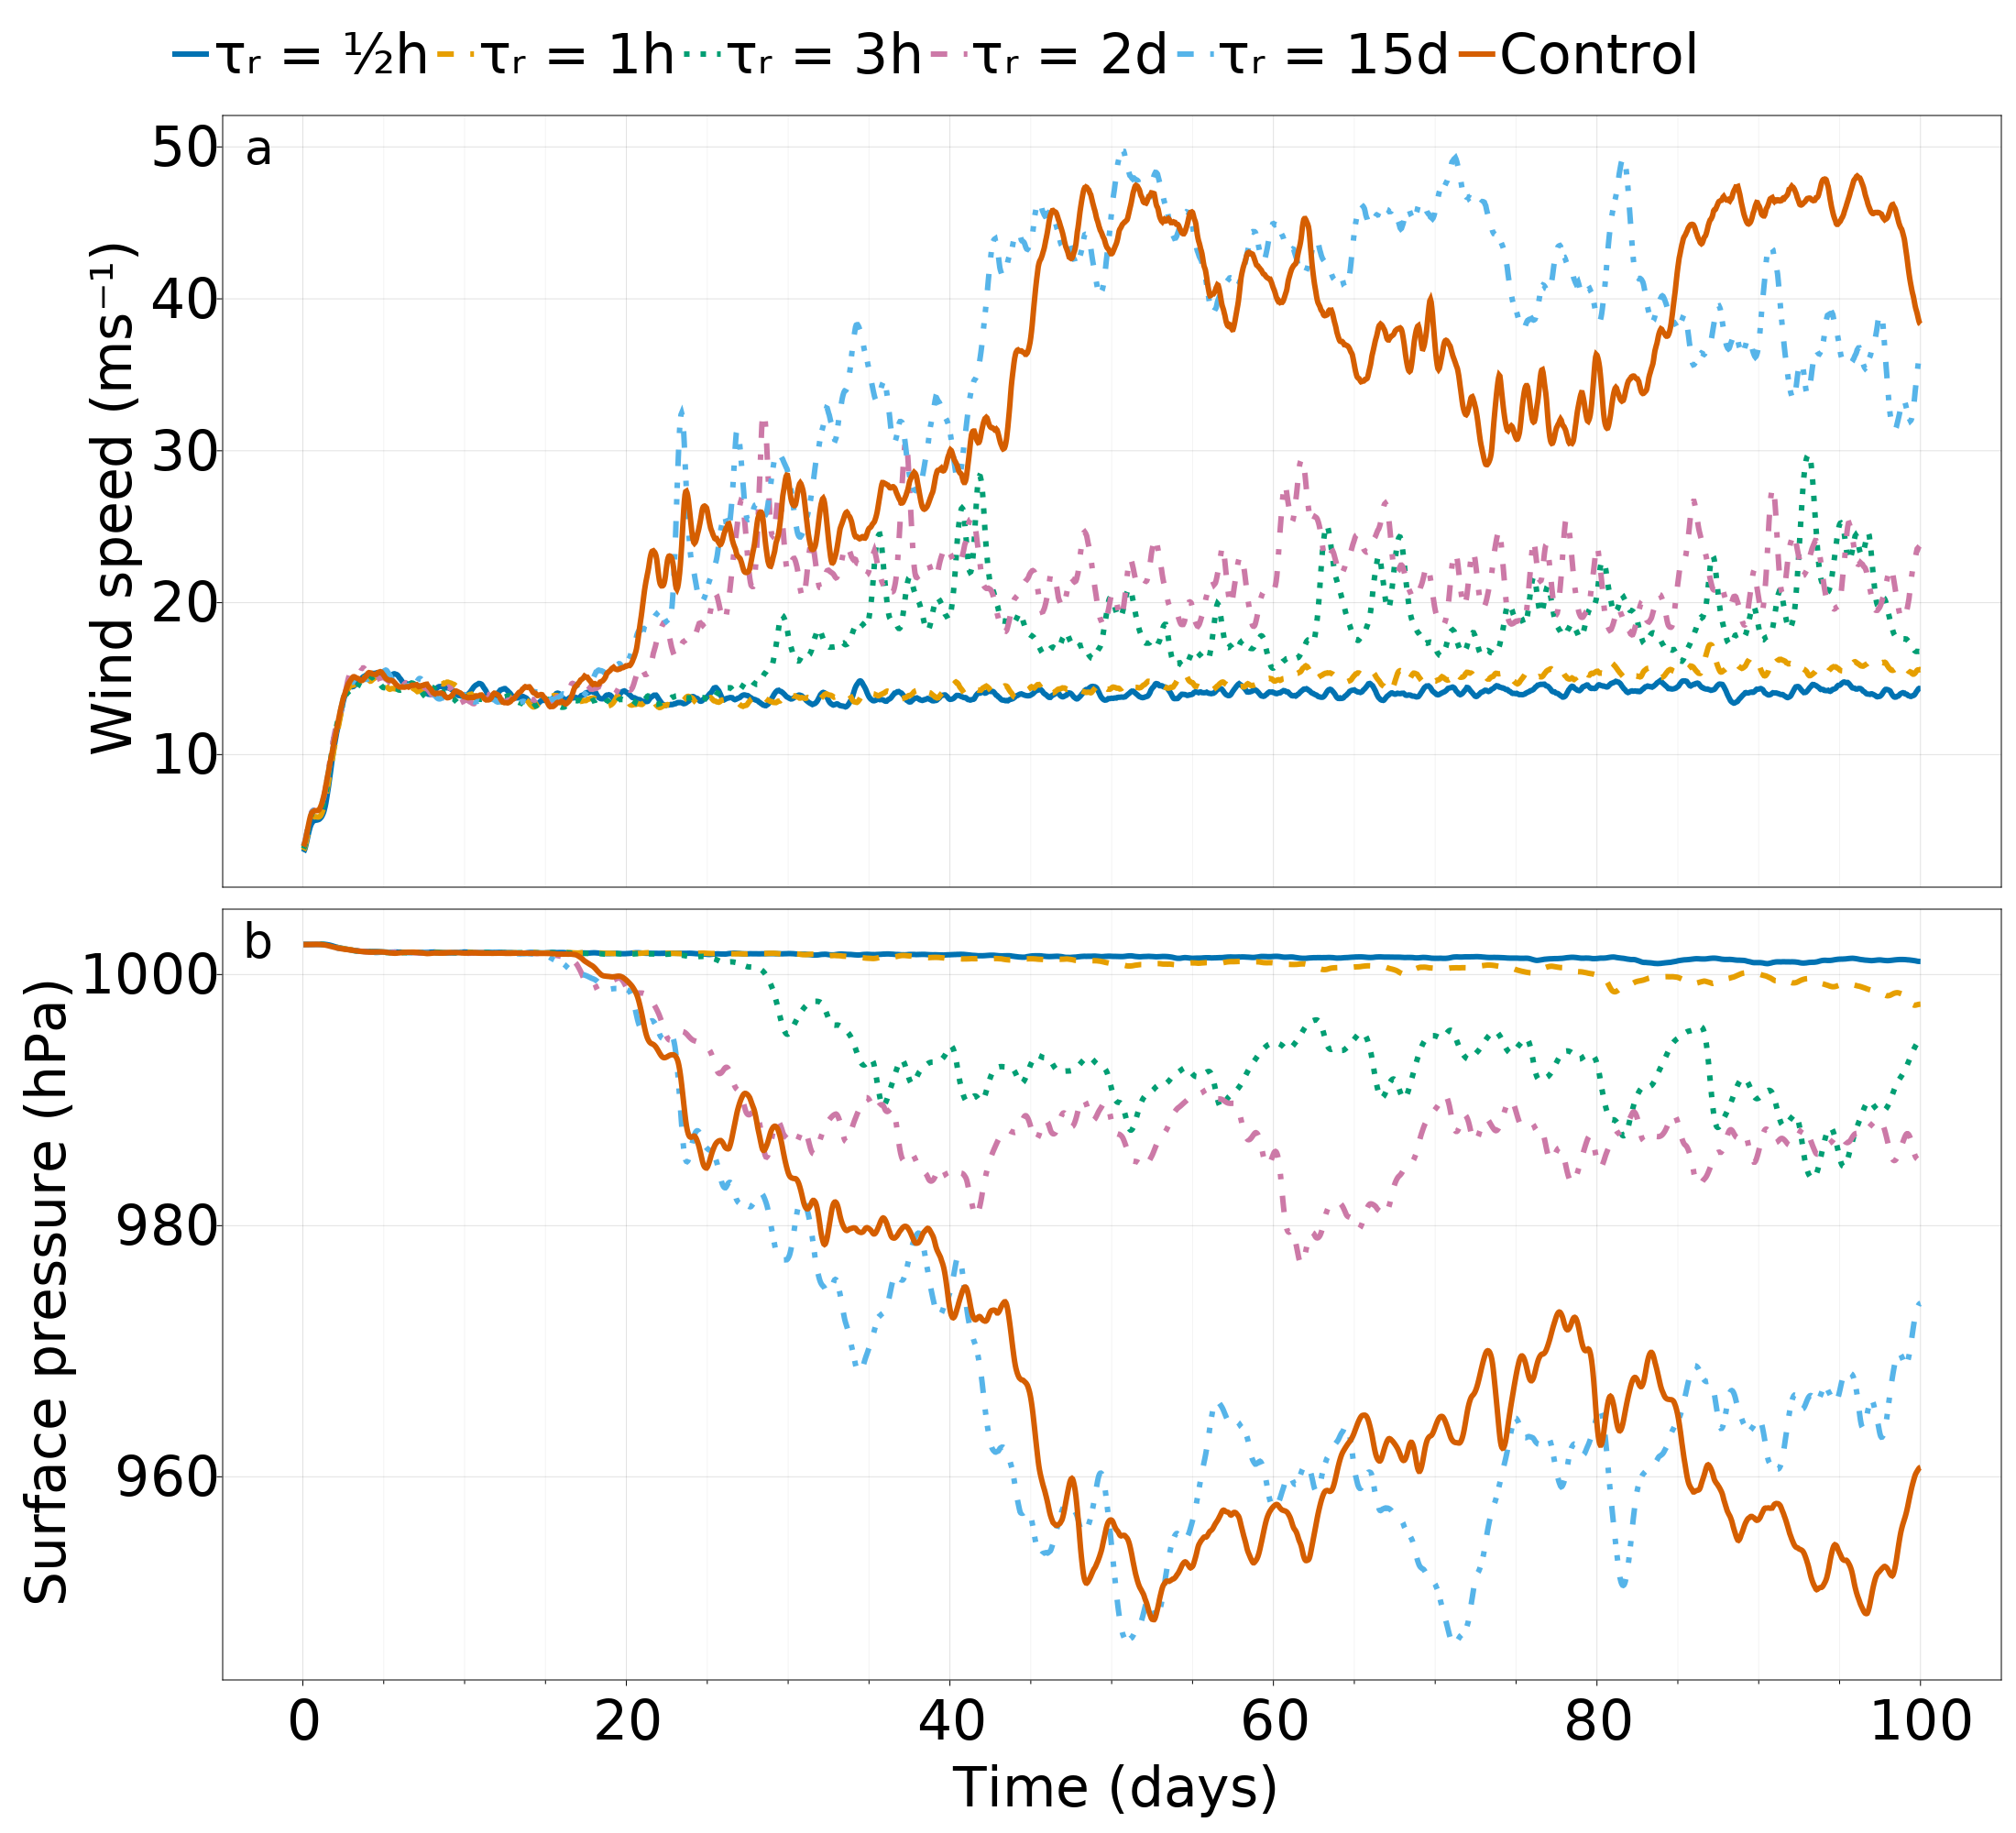

In [16]:
fig = Figure(resolution = (2200,2000))#,font = noto_sans)
ax1 = fig[2,1] = Axis(fig,xlabelsize=axis_label_fontsize, ylabel = "Wind speed (ms⁻¹)",ylabelsize=axis_label_fontsize)
ax2 = fig[3,1] = Axis(fig,xlabel = "Time (days)",xlabelsize=axis_label_fontsize, ylabel = "Surface pressure (hPa)",ylabelsize=axis_label_fontsize)

indices_to_plot = [1,2,4,9,12,13]

lines_sp_list = []
lines_pres_list = []

for (i,line) in enumerate(lines_sp[indices_to_plot])
    push!(lines_sp_list,lines!(ax1,times,line))
end

for (i,line) in enumerate(lines_pres[indices_to_plot])
    push!(lines_pres_list,lines!(ax2,times,line))
end

legend_exp = fig[1,1] = Legend(
        fig, lines_sp_list, experiment_labels_for_plot[indices_to_plot],
        halign = :left, orientation = :horizontal, tellwidth=false,
        tellheight=true,framevisible=false,patchsize=(40.0f0,4.0f0), labelsize = legend_labelsize, nbanks=1, margin = (-65.0f0, 0.0f0, 0.0f0, 0.0f0) ) 
Label(fig[2, 1, TopLeft()], "a", textsize = 52,
        padding = (0, -50, -70, 0), halign = :right)
Label(fig[3, 1, TopLeft()], "b", textsize = 52,
        padding = (0, -50, -70, 0), halign = :right)
hidexdecorations!(ax1,grid=false,minorgrid=false)
fig

In [17]:
save(joinpath(plots_dir,"time_vs_speed_varying_tau.png"), fig,px_per_unit=4)
save(joinpath(plots_dir,"time_vs_speed_varying_tau.eps"), fig)
save(joinpath(plots_dir,"time_vs_speed_varying_tau.pdf"), fig)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000000d48d6f0, 1650.0, 1500.0, IOContext(IOStream(<file /global/u2/a/aramreye/RamirezReyes_MECFeedbackInTCWorld/plotsandanimations/time_vs_speed_varying_tau.pdf>)))


In [20]:
set_theme!(fontsize=60,
    Axis = (
        xminorticksvisible = true,
        yminorticksvisible = false,
        xminorgridvisible = true,
        yminorgridvisible = false,
        xticks = LinearTicks(6),
        xminorticks = IntervalsBetween(4)),
    Scatter = (cycle = Cycle([:color, :marker], covary = true),),
    Lines = (cycle = Cycle([:color]), linewidth = 6.0f0)
)
subplot_label_fontsize = 60.0f0
axis_label_fontsize = 60.0f0
linewidth = 1.5f0
legend_labelsize = 60.0f0

60.0f0

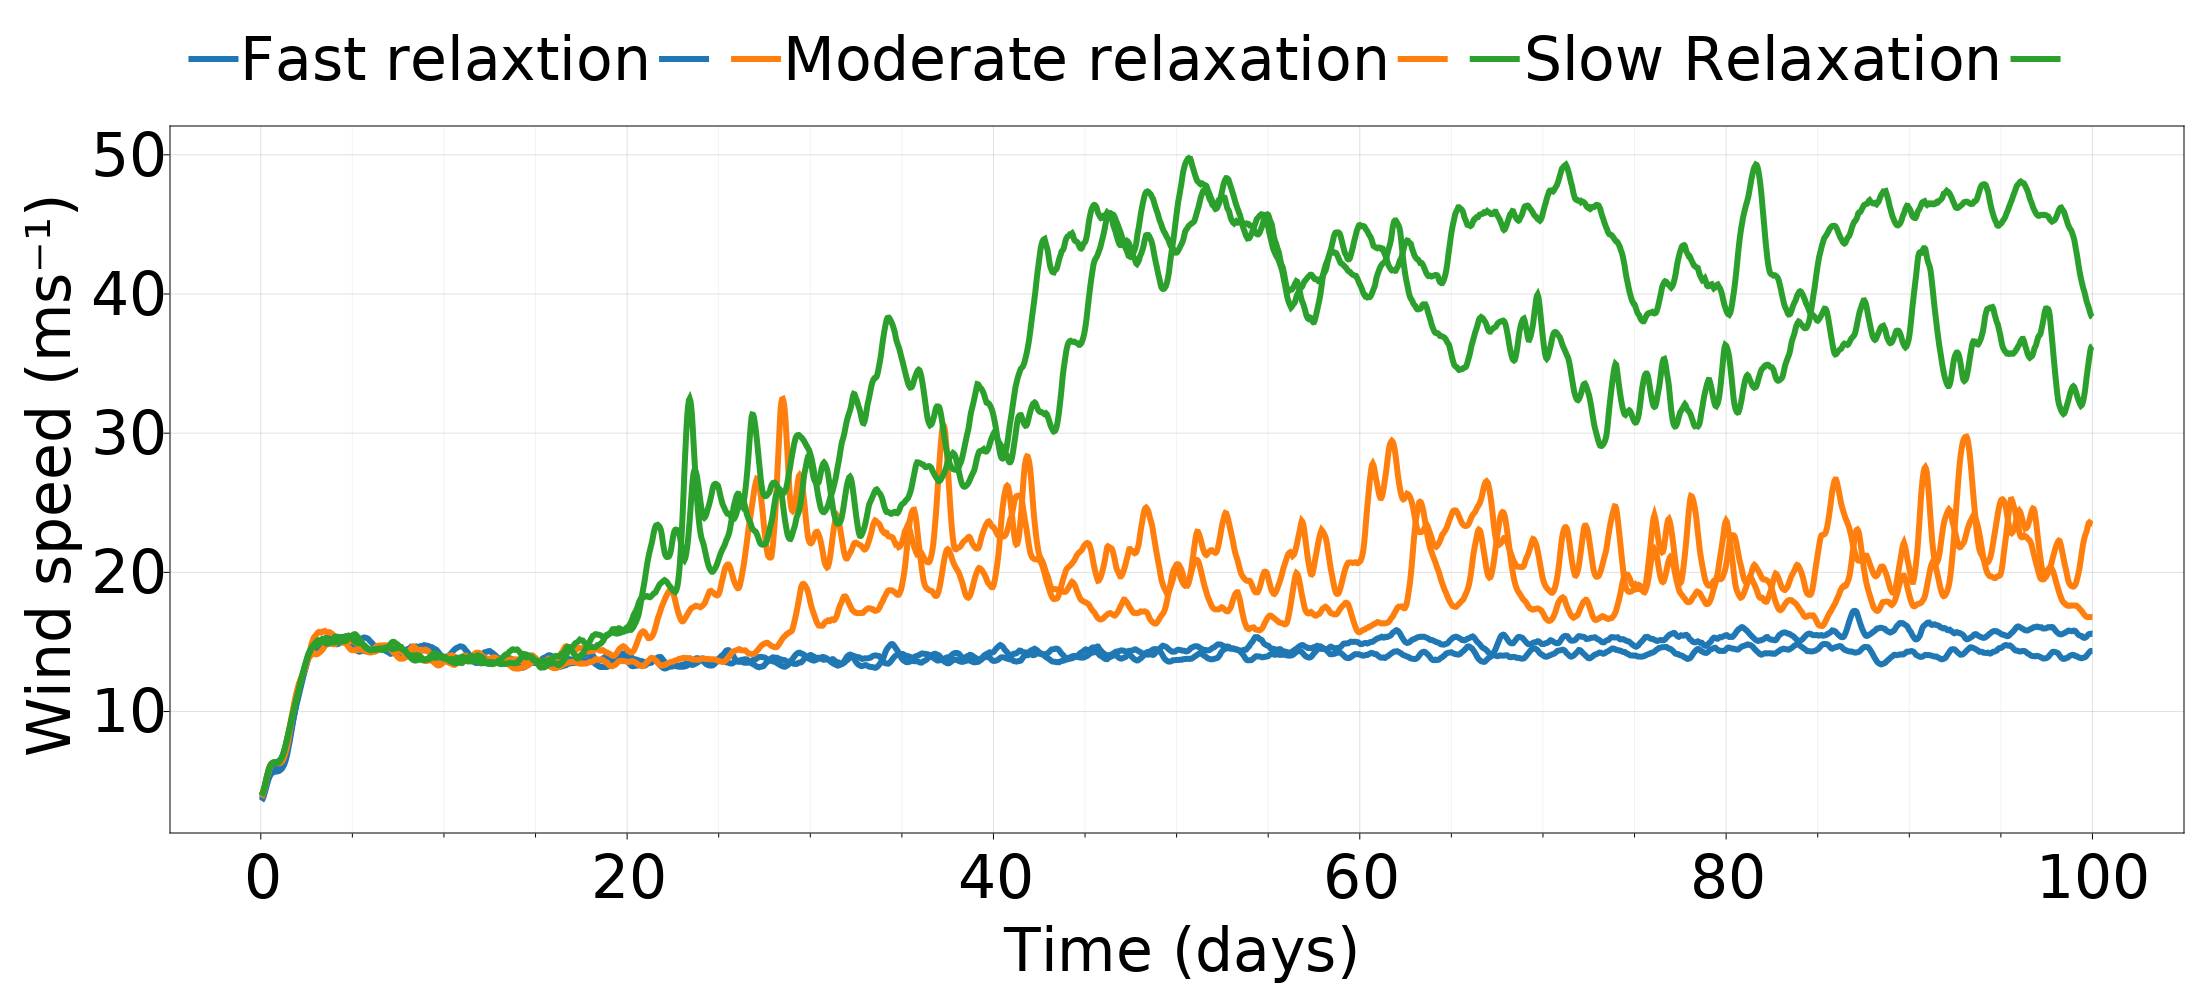

In [43]:
fig = Figure(resolution = (2200,1000))#,font = noto_sans)
ax1 = fig[2,1] = Axis(fig,xlabelsize=axis_label_fontsize,xlabel = "Time (days)", ylabel = "Wind speed (ms⁻¹)",ylabelsize=axis_label_fontsize)

indices_to_plot = [1,2,4,9,12,13]

lines_sp_list = []
lines_pres_list = []
experiment_labels_for_plot2 = ["Fast relaxtion","", "Moderate relaxation","", "Slow Relaxation",""]
colors_to_plot = colorschemes[:tab10][[1,1,2,2,3,3]]
for (i,line) in enumerate(lines_sp[indices_to_plot])
    push!(lines_sp_list,lines!(ax1,times,line, color=colors_to_plot[i]))
end


legend_exp = fig[1,1] = Legend(
        fig, lines_sp_list, experiment_labels_for_plot2,
        halign = :left, orientation = :horizontal, tellwidth=false,
        tellheight=true,framevisible=false,patchsize=(50.0f0,40.0f0), labelsize = legend_labelsize, nbanks=1, margin = (10.0f0, 0.0f0, 0.0f0, 0.0f0) ) 
fig

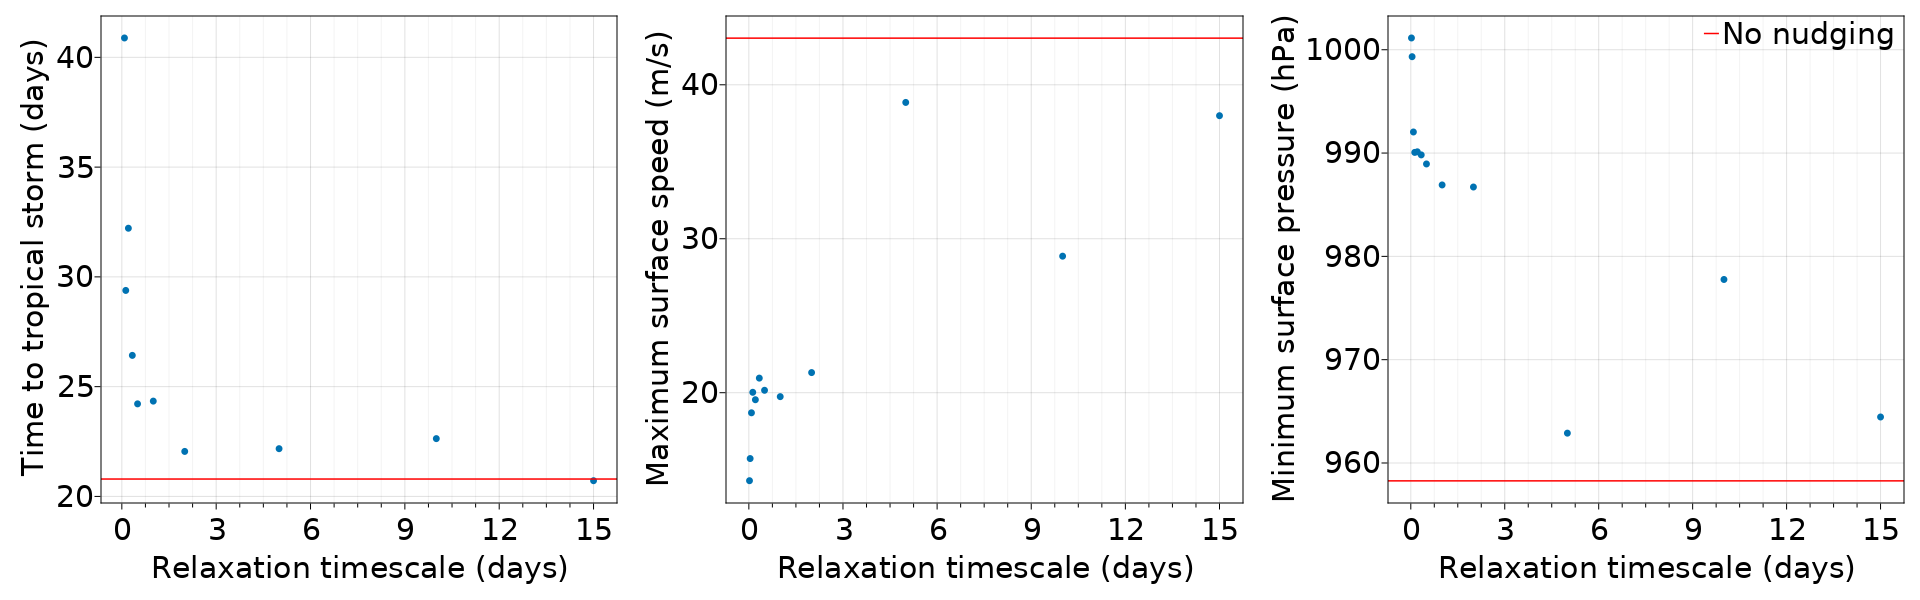

In [30]:
fig = Figure(resolution = (1920,600))#,font = noto_sans)
#set_theme!(colgap = 10, rowgap = 10)
#ax1 = fig[1,1] = Axis(fig, xlabel = "Relaxation timescale (hours)",xlabelsize=axis_label_fontsize, ylabel = "Time to tropical storm (days)",ylabelsize=axis_label_fontsize, xscale = log)
ax1 = fig[1,1] = Axis(fig, xlabel = "Relaxation timescale (days)",xlabelsize=axis_label_fontsize, 
    ylabel = "Time to tropical storm (days)",ylabelsize=axis_label_fontsize )
taus_genesis = [2,3,5,8, 12, 24, 48, 120, 240, 15*24]./24
taus_other = [1/2, 1,2, 3,5,8, 12, 24, 48,120, 240, 15*24]./24
scatter!(ax1,taus_genesis,genesis_times[1:end-1])
l1 = hlines!(ax1,genesis_times[end],color=:red)

ax2 = fig[1,2] = Axis(fig, xlabel = "Relaxation timescale (days)",xlabelsize=axis_label_fontsize, 
    ylabel = "Maximum surface speed (m/s)",ylabelsize=axis_label_fontsize)
taus = [3,5,8, 12, 24, 48, 240, 15*24]./24
scatter!(ax2,taus_other,max_sp[1:end-1])
l2 = hlines!(ax2,max_sp[end],color=:red)

ax3 = fig[1,3] = Axis(fig, xlabel = "Relaxation timescale (days)",xlabelsize=axis_label_fontsize, 
    ylabel = "Minimum surface pressure (hPa)",ylabelsize=axis_label_fontsize)
taus = [3,5,8, 12, 24, 48, 240, 15*24]./24
scatter!(ax3,taus_other,min_pres[1:end-1])
l3 = hlines!(ax3,min_pres[end],color=:red)
#ylims!(ax1,(10,45))
#xlims!(ax1,(0.1,380))
# legend_exp = fig[1,1] = Legend(
#         fig, [l1], ["No nudging"],
#          halign = :right, valign = :top, orientation = :vertical, tellwidth=false,
#         tellheight=false,framevisible=false,labelsize = legend_labelsize,patchsize=(15.0f0,3.0f0), padding=(10.0f0,13.0f0,0,0))#, margin = (0.0f0, 0.0f0, -15.0f0, 0.0f0), ) 

# legend_exp = fig[1,2] = Legend(
#         fig, [l2], ["No nudging"],
#          halign = :right, valign = :top, orientation = :vertical, tellwidth=false,
#         tellheight=false,framevisible=false,labelsize = legend_labelsize,patchsize=(15.0f0,3.0f0), padding=(10.0f0,13.0f0,0,0))

legend_exp = fig[1,3] = Legend(
        fig, [l3], ["No nudging"],
         halign = :right, valign = :top, orientation = :vertical, tellwidth=false,
        tellheight=false,framevisible=false,labelsize = legend_labelsize,patchsize=(15.0f0,3.0f0), padding=(10.0f0,13.0f0,0,0))

fig

In [31]:
save(joinpath(plots_dir,"tau_vs_severalmetrics.png"), fig,px_per_unit=4)
save(joinpath(plots_dir,"tau_vs_severalmetrics.eps"), fig)
save(joinpath(plots_dir,"tau_vs_severalmetrics.pdf"), fig)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x0000000011862af0, 1440.0, 450.0, IOContext(IOStream(<file /global/u2/a/aramreye/RamirezReyes_MECFeedbackInTCWorld/plotsandanimations/tau_vs_severalmetrics.pdf>)))


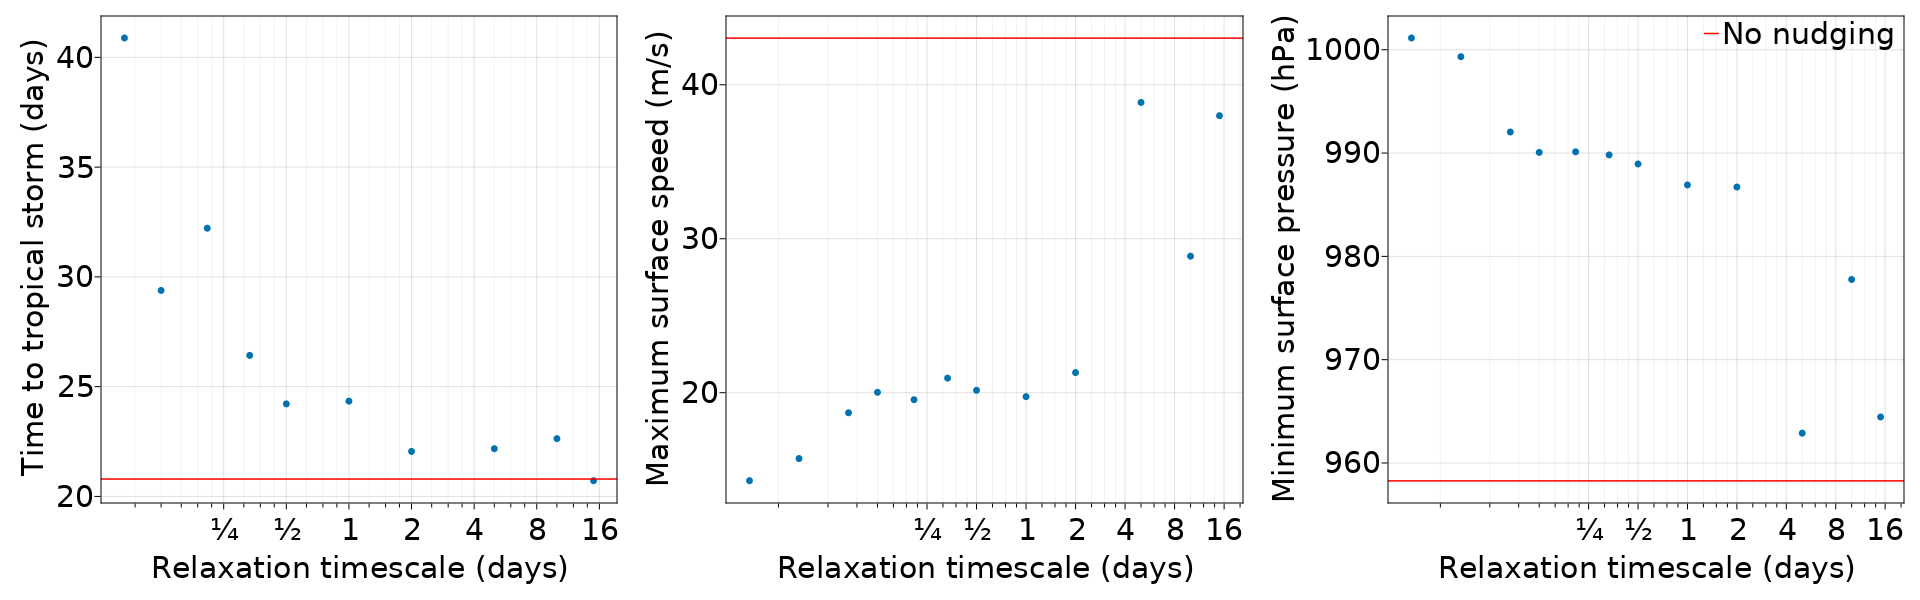

In [32]:
fig = Figure(resolution = (1920,600))#,font = noto_sans)
#set_theme!(colgap = 10, rowgap = 10)
#ax1 = fig[1,1] = Axis(fig, xlabel = "Relaxation timescale (hours)",xlabelsize=axis_label_fontsize, ylabel = "Time to tropical storm (days)",ylabelsize=axis_label_fontsize, xscale = log)
ax1 = fig[1,1] = Axis(fig, xlabel = "Relaxation timescale (days)",xlabelsize=axis_label_fontsize, 
    ylabel = "Time to tropical storm (days)",ylabelsize=axis_label_fontsize, xscale = log,
    xticks = ([6,12,24,48,96,192,384]./24,["¼", "½", "1","2","4","8","16"]))
taus_genesis = [2,3,5,8, 12, 24, 48, 120, 240, 15*24]./24
taus_other = [1/2, 1,2, 3,5,8, 12, 24, 48,120, 240, 15*24]./24
scatter!(ax1,taus_genesis,genesis_times[1:end-1])
l1 = hlines!(ax1,genesis_times[end],color=:red)

ax2 = fig[1,2] = Axis(fig, xlabel = "Relaxation timescale (days)",xlabelsize=axis_label_fontsize, 
    ylabel = "Maximum surface speed (m/s)",ylabelsize=axis_label_fontsize, xscale = log,
    xticks = ([6,12,24,48,96,192,384]./24,["¼", "½", "1","2","4","8","16"]))
taus = [3,5,8, 12, 24, 48, 240, 15*24]./24
scatter!(ax2,taus_other,max_sp[1:end-1])
l2 = hlines!(ax2,max_sp[end],color=:red)

ax3 = fig[1,3] = Axis(fig, xlabel = "Relaxation timescale (days)",xlabelsize=axis_label_fontsize, 
    ylabel = "Minimum surface pressure (hPa)",ylabelsize=axis_label_fontsize, xscale = log,
    xticks = ([6,12,24,48,96,192,384]./24,["¼", "½", "1","2","4","8","16"]))
taus = [3,5,8, 12, 24, 48, 240, 15*24]./24
scatter!(ax3,taus_other,min_pres[1:end-1])
l3 = hlines!(ax3,min_pres[end],color=:red)
#ylims!(ax1,(10,45))
#xlims!(ax1,(0.1,380))
# legend_exp = fig[1,1] = Legend(
#         fig, [l1], ["No nudging"],
#          halign = :right, valign = :top, orientation = :vertical, tellwidth=false,
#         tellheight=false,framevisible=false,labelsize = legend_labelsize,patchsize=(15.0f0,3.0f0), padding=(10.0f0,13.0f0,0,0))#, margin = (0.0f0, 0.0f0, -15.0f0, 0.0f0), ) 

# legend_exp = fig[1,2] = Legend(
#         fig, [l2], ["No nudging"],
#          halign = :right, valign = :top, orientation = :vertical, tellwidth=false,
#         tellheight=false,framevisible=false,labelsize = legend_labelsize,patchsize=(15.0f0,3.0f0), padding=(10.0f0,13.0f0,0,0))

legend_exp = fig[1,3] = Legend(
        fig, [l3], ["No nudging"],
         halign = :right, valign = :top, orientation = :vertical, tellwidth=false,
        tellheight=false,framevisible=false,labelsize = legend_labelsize,patchsize=(15.0f0,3.0f0), padding=(10.0f0,13.0f0,0,0))

fig

In [33]:
save(joinpath(plots_dir,"tau_vs_severalmetrics_logscale.png"), fig,px_per_unit=4)
save(joinpath(plots_dir,"tau_vs_severalmetrics_logscale.eps"), fig)
save(joinpath(plots_dir,"tau_vs_severalmetrics_logscale.pdf"), fig)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x00000000053fdd60, 1440.0, 450.0, IOContext(IOStream(<file /global/u2/a/aramreye/RamirezReyes_MECFeedbackInTCWorld/plotsandanimations/tau_vs_severalmetrics_logscale.pdf>)))
